<a href="https://colab.research.google.com/github/Cybertocks/Logo-dec/blob/master/EmojiDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll be building a logo
 discriminator detector using our own custom created dataset. We are also going to host this on the server so you can show it off to your friends

<!-- The 3 types of monkeys that will be considered are gorrilas, chimpanzees and bonobos because why not?!! -->

We'll be making use of fastai for solving this problem so we just install it from pypi using pip

In [1]:
!pip -q install fastai2

     |████████████████████████████████| 184kB 9.8MB/s 


In [2]:
! pip -q install azure-cognitiveservices-search-imagesearch

     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 40kB 6.9MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 2.3MB 28.0MB/s 


! pip install nbdev

import the library into the notebook. We'll be importing everything in the vision module

In [0]:
from fastai2.vision.all import *
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth

In [0]:
# helper to download images
def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

## Building the Dataset

We'll be making use of Bing's search API for this because it is very straightforward and easy to use. There are also other ways to build custom dataset using web crawlers on other search engines but they won't be discussed here.

Visit this [link](https://azure.microsoft.com/en-us/try/cognitive-services/), navigate to search API, on Bing Search APIs v7 click on get API Key, a modal will pop up where you can choose to try the service as a guest user, accept the terms and conditions, sign in with an option of your choice, wait for some seconds and boom! all your Api keys for the Bing Search will appear on your dashboard. Copy the one that ends in '/images'. That is our API key. Put the API key in the variable API_key as shown below

In [0]:
API_key = '703df11947c143e7ab7ef1e129e23548'

Let's test our function out

In [0]:
url = 'https://th.bing.com/th/id/OIP.h2Gc3aUYlLD2E-U7TMYnqAHaFS?w=290&h=208&c=7&o=5&dpr=1.25&pid=1.7'
puma_url = 'http://orignallogo.com/wp-content/uploads/2018/01/Puma-Logo-Design-Vector-Free-Download.jpg'

In [23]:
# this will download at most 150 images of size 128, 128 for us
res = search_images_bing(API_key, 'nike logo jpg')
imgs = res.attrgot('content_url')
len(imgs)

150

In [0]:
base_dir = Path('/content')
(base_dir/'images').mkdir(parents=True, exist_ok=True)

Thankfully fastai has a method `download_url` which we can use to make requests to a single url and download it's content into a file in `dest`

In [37]:
dest = 'images/nike.jpg'
download_url(url, dest)
dest = 'images/puma.jpg'
download_url(puma_url, dest)

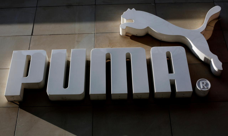

In [38]:
img = PILImage.create(dest)
img.to_thumb(228)

It works!!

We now make use of another fastai method called `download_images` to download multiple images and store them in a folder called `dest`

Defining the folder names for each of the classes

In [0]:
folder_names  = ['Nike', 'Puma', 'Adidas', 'New Balance', 'Vans', 'Reebok']
path = Path('Logos')

Lets download the full dataset by querying bing continuously

In [40]:
path.mkdir(parents=True, exist_ok=True)
for nm in folder_names:
  if not (path/nm).exists():
    dest = path/nm
    dest.mkdir(exist_ok=True)
    res = search_images_bing(API_key, f'{nm} logo')
    download_images(dest, urls=res.attrgot('content_url'))


 Download of http://mitsloan.mit.edu/sustainability/images/large/Nike.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p Logos/Nike
$ cd Logos/Nike
$ wget -c http://mitsloan.mit.edu/sustainability/images/large/Nike.jpg
$ tar xf Nike.jpg
 And re-run your code once the download is successful



In [0]:
# shutil.rmtree(path)

Extract all the image files that have just been downloaded from the grandparent `bears` folder using the get_image_files. It looks into all the folders with recurse and returns and `L` list type which is a normal python list but supercharged

In [41]:
all_logos = get_image_files(path)
all_logos, len(all_logos)

((#888) [Path('Logos/New Balance/00000118.png'),Path('Logos/New Balance/00000025.jpg'),Path('Logos/New Balance/00000106.jpg'),Path('Logos/New Balance/00000031.png'),Path('Logos/New Balance/00000040.jpg'),Path('Logos/New Balance/00000080.jpg'),Path('Logos/New Balance/00000044.jpg'),Path('Logos/New Balance/00000128.png'),Path('Logos/New Balance/00000028.png'),Path('Logos/New Balance/00000146.jpg')...],
 888)

While downloading the images, some images may have been corrupted/broken so we have to check to see if there are any of such images and remove them from our dataset. Luckily fastai has the `verify_images` method which looks into the image `L` list and selects all the ones that are broken or can't be opened and stores them in a list object

In [42]:
broken = verify_images(all_logos)
broken

(#24) [Path('Logos/New Balance/00000041.jpg'),Path('Logos/New Balance/00000060.png'),Path('Logos/New Balance/00000107.jpg'),Path('Logos/New Balance/00000093.png'),Path('Logos/New Balance/00000088.png'),Path('Logos/New Balance/00000019.svg'),Path('Logos/New Balance/00000020.png'),Path('Logos/New Balance/00000075.jpg'),Path('Logos/Vans/00000129.svg'),Path('Logos/Vans/00000108.svg')...]

As we can see, we have 10 broken images. Let's try to open one and see what happens

In [43]:
PILImage.create(broken[0])

UnidentifiedImageError: ignored

See? I told you it was broken. Look at the Exception message. The Image still exists in the directory but it is broken

Remember I told you that `verify_images` returns an `L` list type. This `L` list type has a `map` method which you can use to recursively perfrom operations on the elements in the `L`. The operation we want to perform on this `L` type object is to go into it, pick out all it's elements and use them on any function in it's `map`. The function in the map of the `L` has to be something that can remove the image paths are broken from their parent paths. All of these can be done using an `unlink` method on the grandparent path

In [44]:
broken.map(Path.unlink) # unlink is a pathlib.Path method

(#24) [None,None,None,None,None,None,None,None,None,None...]

let's check if it worked

In [45]:
PILImage.create(broken[0])

FileNotFoundError: ignored

As we can see from the Exception(error) message, it's been that image has been removed from our directory

## Making a DataBlock

We will be using the midlevel datablock API

We will need some transforms for the items in the CPU and the batches in the GPU

helper util to remove `.gif` files

In [0]:
def remove_gif(path):
  x = L(fn for fn in path if (fn.suffix == '.gif'))
  return x.map(Path.unlink)

In [99]:
# Run once
# remove_gif(get_image_files(path))
# for fn in get_image_files(path):
#   if fn.suffix in ['.jpg', '.JPG', '.JPEG', '.jpeg']:
#     PILImage.create(fn).save(fn)
#   elif fn.suffix in ['.png', '.PNG']:
#     im=PILImage.create(fn)
#     if 'transparency' in im.info.keys():
#       del im.info['transparency']
#     im.save(fn)
#   else:
#     print(fn.suffix)

.tif


In [0]:
# item_tfms = RandomResizedCrop(448, min_scale=0.1)
item_tfms = Resize(224)
# make use of the defualt augmentations
# `mult=2` doubles the values in the `max_rotate`, `max_lighting` and `max_warp` 
# transfroms of the `aug_transforms`
batch_tfms = aug_transforms()

In [0]:
data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items = get_image_files,
                 splitter = RandomSplitter(valid_pct=0.2, seed=42), 
                 get_y=parent_label,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

Remeber that the DataBlock is just as architecture of how we want the data to be fed into the model. We now have to pass in a source to the data that we have into the datablock. It is important that the source passed in can be properly consumed by the get_x (get_item in our case). Since the function there is a `get_image_files`, we have to pass in a the gradparent directory for the images paths to be extracted from it.

In [0]:
dls = data.dataloaders(path)

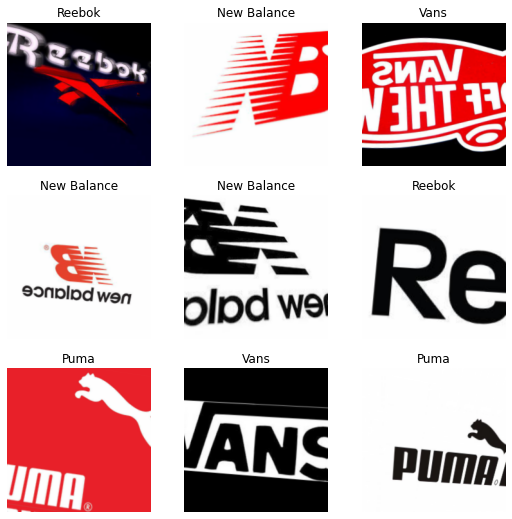

In [108]:
dls.show_batch(max_n=9, nrows=3)

Everything works fine

## Building the Model

This is the exciting part

We'll be using a resnet34 to train wit transfer learning

In [109]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0012022644514217973)

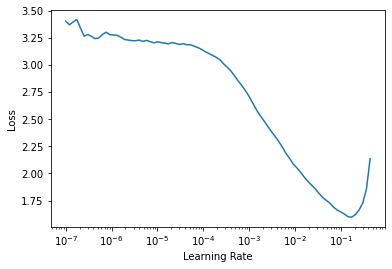

In [110]:
learn.lr_find()

In [111]:
learn.fine_tune(4, 1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,2.653596,1.054905,0.614458,00:19


epoch,train_loss,valid_loss,accuracy,time
0,1.185148,0.567876,0.813253,00:20
1,0.919052,0.393258,0.861446,00:19
2,0.741261,0.281362,0.885542,00:20
3,0.622553,0.285281,0.879518,00:19


## Interpreting Results

Let's see how our model fared on the classificatio problem

In [112]:
interp = ClassificationInterpretation.from_learner(learn)

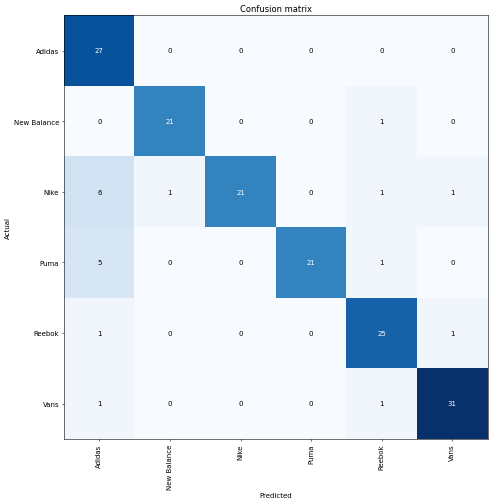

In [113]:
interp.plot_confusion_matrix(figsize=(15, 10), dpi=50)

the model seems to be having a really hard time differentiating between chipanzees and bonobos

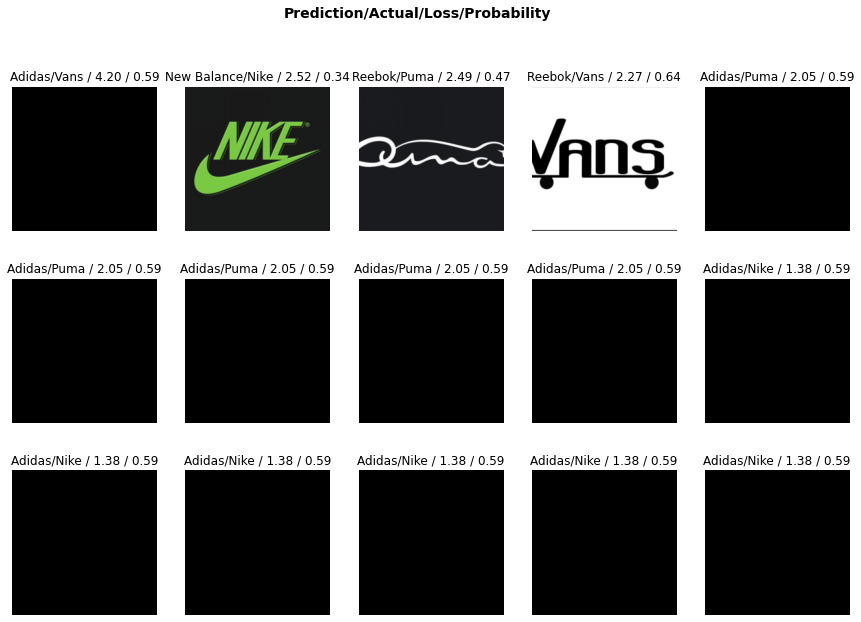

In [114]:
interp.plot_top_losses(15, figsize=(15, 10))

## Image cleanup

We can use the results from the plotted `top_losses` we obtained above to clean up the dataset we have to enable the model learn better

Using Ipython Widgets, we can create a customm widget that allows us to cean up the dataset easily

In [0]:
from fastai2.vision.widgets import *

In [116]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Still doesn't work well in colab

## Making a web APP

Export your model parameters, architecture and dataloader as a serialized pickle

In [0]:
learn.export()

In [0]:
learn = load_learner('export.pkl')

Mkae a prediction

In [121]:
learn.predict('images/nike.jpg')

('Nike',
 tensor(2),
 tensor([4.3680e-06, 1.7363e-07, 9.9998e-01, 1.0972e-05, 6.4961e-06, 2.3327e-07]))

We can see the classes  the learner was trained with by calling `vocab` on the learner's dataloader

In [122]:
learn.dls.vocab

(#6) ['Adidas','New Balance','Nike','Puma','Reebok','Vans']

We create something to use to upload the image

In [0]:
btn_upload = widgets.FileUpload()
btn_upload

colab just loves ruining the flow heh?

We can use a SimpleNamespace to grap the images instead

In [0]:
btn_upload = SimpleNamespace(img='images/nike.jpg')

In [0]:
img = PILImage.create(btn_upload.img)

We can use a widget to output it

In [129]:
out = widgets.Output()
out.clear_output()
with out: display(img.to_thumb(128, 128))
out

Output()

Colab!!!

In [131]:
pred,pred_idx,probs = learn.predict(img)

In [134]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Nike; Probability: 1.0000')

In [136]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [0]:
def on_click_classify(change):
  img = PIlImage.create(btn_upload.data[-1])
  # img = PILImage.create(btn_upload.img)
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  lbl_pred = widgets.Label()
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [0]:
btn_upload = widgets.FileUpload()

Stack everything in a vertical box

In [145]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])